In [4]:
# Evaluating retrievel
    # hitrate
    # mrr

# Evaluation
    # offline evaluation
        # cosine similarity (original ans <--> llm ans)
        # LLM as a judge
    # online evaluation
        # A/B tests
        # user feedback
    # monitoring
        # overall health of the sys
        # how good the answer is

In [5]:
## Load documents with IDs

import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [6]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [7]:
## Load ground truth

import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [8]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [9]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [10]:
# Index data

from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.10.13/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/usr/local/python/3.10.13/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 
es_client.info()

ObjectApiResponse({'name': 'd71b13e1f0dc', 'cluster_name': 'docker-cluster', 'cluster_uuid': '0Va1pTxQQFqru9PeiEW4oA', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [12]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [13]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|█████████████████████████████████████████████████████████████████████| 948/948 [01:19<00:00, 11.96it/s]


In [14]:
# Retrieval

def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [15]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

In [16]:
## The RAG flow

def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [17]:
from groq import Groq
from dotenv import load_dotenv
import os

load_dotenv()
groq_api_key = os.getenv('GROQ_API_KEY')
client = Groq(api_key=groq_api_key)

def llm(prompt, model='llama3-8b-8192'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [18]:
# previously: rag(query: str) -> str
def rag(query: dict, model='llama3-8b-8192') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [19]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [20]:
rag(ground_truth[10])

'Based on the context, the question is answered as follows:\n\nAre sessions recorded if I miss one?\n\nYes, all sessions are recorded.'

In [21]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [22]:
answer_org = 'Yes, everything is recorded, so you won’t miss anything.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_org = model.encode(answer_org)

v_llm.dot(v_org)

0.5877092

In [23]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [24]:
answers = {}

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_org = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_org': answer_org,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

100%|█████████████████████████████████████████████████████████████████| 1830/1830 [1:21:58<00:00,  2.69s/it]


In [25]:
import pandas as pd

df_groq_llama3 = pd.DataFrame(answers.values())

In [26]:
df_groq_llama3.sample(n=5).to_dict(orient='records')

[{'answer_llm': 'Based on the provided context, an estimated weekly time commitment for the course would be around ~10 hours per week, according to the answer in the section "General course-related questions" under the question "How much time do I need for this course?".',
  'answer_org': 'Around ~10 hours per week. Timur Kamaliev did a detailed analysis of how much time students of the previous cohort needed to spend on different modules and projects. Full article',
  'document': 'a6897e8c',
  'question': 'Can you give an estimated weekly time commitment for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'According to the context, the author of the solution for fixing pipenv dependency issues is:\n\nA: Alejandro Aponte\n\nSpecifically, the solution is: Run: `pipenv lock` for fix this problem and dependency files.',
  'answer_org': 'Problem: If you run pipenv install and get this message. Maybe manually change Pipfile and Pipfile.lock.\nSolution: Run: ` pipenv 

In [27]:
df_groq_llama3 = [None] * len(ground_truth)

for i, val in answers.items():
    df_groq_llama3[i] = val.copy()
    df_groq_llama3[i].update(ground_truth[i])

In [28]:
df_groq_llama3[0]

{'answer_llm': 'According to the context, you can sign up for the course by going to the course page (http://mlzoomcamp.com/) and scrolling down to access the course materials. Alternatively, you can use this link: http://mlzoomcamp.com/#syllabus.',
 'answer_org': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [29]:
df_groq_llama3 = pd.DataFrame(df_groq_llama3)
df_groq_llama3

,answer_llm,answer_org,document,question,course
0,"According to the context, you can sign up for ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"I apologize, but I cannot provide a link to si...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Based on the provided CONTEXT, the answer to t...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"According to the context, the answer to the qu...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,"Based on the context provided, I can help you ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp
...,...,...,...,...,...
1825,"Based on the context, here are some suggested ...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp
1826,"Based on the context, it seems that the Machin...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp
1827,"Based on the provided CONTEXT, you can incorpo...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp
1828,"According to the context, Annaliese Bronz gave...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp


In [30]:
!mkdir data
df_groq_llama3.to_csv('data/results-groql3.csv', index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mkdir: cannot create directory ‘data’: File exists


In [31]:
!head data/results-groql3.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_org,document,question,course
"According to the context, you can sign up for the course by going to the course page (http://mlzoomcamp.com/) and scrolling down to access the course materials. Alternatively, you can use this link: http://mlzoomcamp.com/#syllabus.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"I apologize, but I cannot provide a link to sign up as there is no mention of sign up in the provided FAQ database. The FAQ only provides information on technical questions and answers, and links to other resources. The only mention of a link is 

## Evaluating with mixtral-8x7b-32768

In [ ]:
rag(ground_truth[10], model="mixtral-8x7b-32768")

In [30]:
# speeding things up --script--
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=1)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [31]:
def process_record(rec):

    model =  "mixtral-8x7b-32768"
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_org = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_org': answer_org,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [32]:
process_record(ground_truth[10])

{'answer_llm': 'Yes, all sessions are recorded, including live office hours sessions. Therefore, if you miss a session, you can watch the recording later. You can find the recordings in the course playlist on YouTube. If you have any questions, you can ask them in Slack or submit them in advance for office hours.',
 'answer_org': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
groq_mixtral = map_progress(pool, ground_truth, process_record)

df_groq_mixtral = pd.DataFrame(groq_mixtral.values())

df_groq_mixtral = [None] * len(ground_truth)

for i, val in answers.items():
    results_groq__mixtral[i] = val.copy()
    results_groq__mixtral[i].update(ground_truth[i])

df_groq_mixtral.to_csv('data/results-groqmxt', index=False)

## Cosine similarity

In [38]:
results_groql3 = df_groq_llama3.to_dict(orient='records')
record = results_groql3[2]
record

{'answer_llm': 'Based on the provided CONTEXT, the answer to the QUESTION "Is there an FAQ for this Machine Learning course?" is:\n\nThere is an FAQ for the Machine Learning course, specifically a "Machine Learning Zoomcamp FAQ" document that exists, as mentioned in the answer to the question "How do I sign up?"',
 'answer_org': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Is there an FAQ for this Machine Learning course?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.5936027765274048}

In [33]:
def compute_similarity(record):
    answer_org = record['answer_org']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_org = model.encode(answer_org)
    
    return v_llm.dot(v_org)
    

In [34]:
similarity = []

for record in tqdm(results_groql3):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|███████████████████████████████████████████████████████████████████| 1830/1830 [02:33<00:00, 11.93it/s]


In [39]:
df_groq_llama3['cosine'] = similarity

In [42]:
df_groq_llama3.head(1)

,answer_llm,answer_org,document,question,course,cosine
0,"According to the context, you can sign up for ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.323967


In [44]:
df_groq_llama3.iloc[3].to_dict()

{'answer_llm': 'According to the context, the answer to the question "Does this course have a GitHub repository for the sign-up link?" is NOT explicitly mentioned. However, based on the information provided, \n\n* The course recommends students create their own GitHub repository with notes, homework, and projects.\n* Students need to provide the URL to their repository to receive a grade.\n* The course also provides information on how to connect Saturn Cloud to GitHub, suggesting that GitHub is used for storing and sharing code.\n\nTherefore, I would answer the question: Although it\'s not explicitly stated that the course has a GitHub repository for the sign-up link, it\'s implied that students will be using GitHub for storing and sharing their work, and will need to create their own repository.',
 'answer_org': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked qui

In [45]:
df_groq_llama3['cosine'].describe()

count    1830.000000
mean        0.641176
std         0.222132
min        -0.121299
25%         0.542093
50%         0.695392
75%         0.799482
max         0.996049
Name: cosine, dtype: float64

In [64]:
df_groq_llama3.to_csv('groq_llama3_cos.csv', index=False)

/tmp/ipykernel_3584/1074231991.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_groq_llama3['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

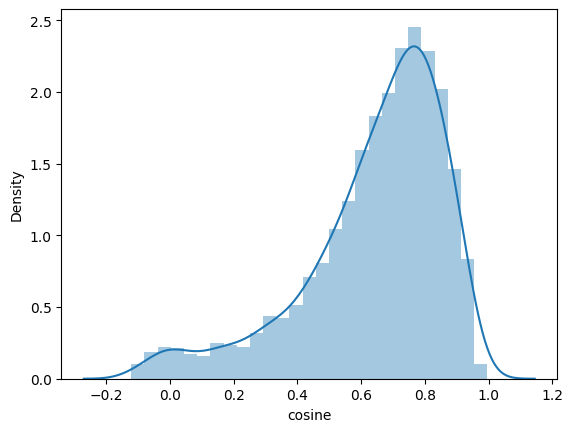

In [65]:
import seaborn as sns
sns.distplot(df_groq_llama3['cosine'])

## LLM as a judge

In [144]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_org}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [145]:
df_sample = df_groq_llama3.sample(n=150, random_state=1)
samples = df_sample.to_dict(orient='records')

In [146]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is:\n\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)',
 'answer_org': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.8290197253227234}

In [147]:
prompt = prompt1_template.format(**record)

In [148]:
answer = llm(prompt, model='llama3-8b-8192')

In [149]:
import json
json.loads(answer)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer directly quotes the syntax for using precision_recall_fscore_support in Python, which is the same as the original answer. The content matches exactly, making it relevant.'}

In [153]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='llama3-8b-8192')
    evaluations.append(evaluation)

100%|█████████████████████████████████████████████████████████████████████| 150/150 [05:24<00:00,  2.16s/it]


In [155]:
# json_evaluations = []

# for i, str_eval in enumerate(evaluations):
#     json_eval = json.loads(str_eval)
#     json_evaluations.append(json_eval)


import json

json_evaluations = []

for i, str_eval in enumerate(evaluations):
    try:
        json_eval = json.loads(str_eval)
        json_evaluations.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Invalid JSON: {str_eval}")
        # Handle the error or skip the invalid JSON
        continue

Error decoding JSON at index 2: Expecting value: line 1 column 1 (char 0)
Invalid JSON: Here is my evaluation:

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer is a direct quote from the original answer, which is a correct response to the question 'What command launches a container image in interactive mode?' The context provided in the generated answer also serves to further explain the purpose of the command, making it even more relevant to the original answer."
}
Error decoding JSON at index 4: Expecting value: line 1 column 1 (char 0)
Invalid JSON: Here is the evaluation in JSON format:

{
  "Relevance": "PARTLY_RELEVANT",
  "Explanation": "The generated answer discusses potential causes of a pipeline version error due to version conflicts between Scikit-Learn, which is somewhat relevant to the original answer. However, the specific context of Docker builds, error messages, and steps to resolve the issue in the original answer are not addressed in the generated 

In [130]:
str_answer 

'Here is the evaluation result in JSON format:\n\n{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer is relevant because it provides the exact syntax and format for using precision_recall_fscore_support in Python, which is identical to the original answer. The only difference is that the original answer is presented as an example, whereas the generated answer is presented as a direct answer to the question."\n}'

In [156]:
df_evaluations = pd.DataFrame(json_evaluations)
df_evaluations

,Relevance,Explanation
0,RELEVANT,The generated answer accurately provides the s...
1,RELEVANT,The generated answer accurately identifies the...
2,RELEVANT,The generated answer is highly relevant as it ...
3,RELEVANT,The generated answer is relevant to the origin...
4,RELEVANT,The generated answer is relevant to the origin...
5,NON_RELEVANT,The generated answer is not relevant to the ta...
6,RELEVANT,The generated answer is relevant to the origin...
7,PARTLY_RELEVANT,The generated answer partially matches the con...
8,RELEVANT,The generated answer provides a clear explanat...
9,RELEVANT,The generated answer is highly relevant to the...


In [157]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           26
PARTLY_RELEVANT    15
NON_RELEVANT        4
Name: count, dtype: int64

In [158]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
5,NON_RELEVANT,The generated answer is not relevant to the ta...
12,NON_RELEVANT,The generated answer does not address the orig...
19,NON_RELEVANT,The generated answer is entirely unrelated to ...
35,NON_RELEVANT,The generated question and answer are complete...


In [161]:
answers2 = []
for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    answer = llm(prompt, model='llama3-8b-8192')
    answers2.append(answer)

json_answers2 = []
# for i, str_answer in enumerate(answers2):
#     json_answer = json.loads(str_answer)
#     json_answers2.append(json_answer)

for i, str_eval in enumerate(answers2):
    try:
        json_answer = json.loads(str_eval)
        json_answers2.append(json_answer)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")
        print(f"Invalid JSON: {json_answer}")
        # Handle the error or skip the invalid JSON
        continue

df_evaluations2 = pd.DataFrame(json_answers2)
df_evaluations2

df_evaluations2.Relevance.value_counts()

df_evaluations2[df_evaluations2.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

100%|█████████████████████████████████████████████████████████████████████| 150/150 [05:23<00:00,  2.16s/it]

Error decoding JSON at index 0: Expecting value: line 1 column 1 (char 0)
Invalid JSON: {'Relevance': 'RELEVANT', 'Explanation': 'The generated answer directly addresses the question of how to modify scripts to avoid pickle errors when using waitress. The answer provides a specific solution to the problem, mentioning the use of a separate module for the custom column transformer class to avoid pickle errors. The answer is relevant to the question, providing a concrete and relevant solution to the problem.'}
Error decoding JSON at index 1: Expecting value: line 1 column 1 (char 0)
Invalid JSON: {'Relevance': 'RELEVANT', 'Explanation': 'The generated answer directly addresses the question of how to modify scripts to avoid pickle errors when using waitress. The answer provides a specific solution to the problem, mentioning the use of a separate module for the custom column transformer class to avoid pickle errors. The answer is relevant to the question, providing a concrete and relevant s

,Relevance,Explanation
29,NON_RELEVANT,The generated answer does not address the orig...
31,NON_RELEVANT,The generated answer is unrelated to the origi...


In [163]:
df_evaluations2.to_csv('data/evaluations-qa.csv', index=False)